In [1]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

In [2]:
# load the file
path = "mini_sparkify_event_data.json"
spark_df = spark.read.json(path)

In [3]:
# number of records in the dataset
spark_df.count()

286500

In [4]:
# show the schema of the dataset
spark_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# count empty values in every column
for col in spark_df.columns:
    print(col,  spark_df.filter((spark_df[col].isNull()) | (spark_df[col] == "")).count())

artist 58392
auth 0
firstName 8346
gender 8346
itemInSession 0
lastName 8346
length 58392
level 0
location 8346
method 0
page 0
registration 8346
sessionId 0
song 58392
status 0
ts 0
userAgent 8346
userId 8346


In [6]:
# removing empty values from feature userId
df_clean = spark_df.dropna(how = 'any', subset = ['userId'])
df_clean = df_clean.filter(df_clean['userId'] != '')
df_clean.count()

278154

In [7]:
from pyspark.sql.functions import udf
import datetime

# transforming the ts and registation time format
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

df_clean = df_clean.withColumn('event_time', get_date('ts'))
df_clean = df_clean.withColumn('registration_time', get_date('registration'))

df = df_clean.toPandas()
df.head(3).transpose()

,0,1,2
artist,Martha Tilston,Five Iron Frenzy,Adam Lambert
auth,Logged In,Logged In,Logged In
firstName,Colin,Micah,Colin
gender,M,M,M
itemInSession,50,79,51
lastName,Freeman,Long,Freeman
length,277.89016,236.09424,282.8273
level,paid,free,paid
location,"Bakersfield, CA","Boston-Cambridge-Newton, MA-NH","Bakersfield, CA"
method,PUT,PUT,PUT


In [8]:
from pyspark.sql.functions import min, max
# time range in the data set   
print(df_clean.agg({'event_time': 'min'}).collect()[0][0])
print(df_clean.agg({'event_time': 'max'}).collect()[0][0])

2018-10-01 05:31:57
2018-12-03 06:41:16


# Exploratory data Analysis

In [9]:
#show the page content, to see what actions can be used to get informations about churn
df_clean.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
|              Cancel|
|Cancellation Conf...|
+--------------------+



In [10]:
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

# create feature "downgrade"
downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
df_clean = df_clean.withColumn('downgrade_event', downgrade_event('page'))
df_clean = df_clean.withColumn('downgrade', max('downgrade_event').over(Window.partitionBy('userId')))

In [11]:
# create feature "churn"
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_clean = df_clean.withColumn('churn_event', churn_event('page'))
df_clean = df_clean.withColumn('churn', max('churn_event').over(Window.partitionBy('userId')))

In [12]:
df = df_clean.toPandas()
df.head(3).transpose()

,0,1,2
artist,Sleeping With Sirens,Francesca Battistelli,Brutha
auth,Logged In,Logged In,Logged In
firstName,Darianna,Darianna,Darianna
gender,F,F,F
itemInSession,0,1,2
lastName,Carpenter,Carpenter,Carpenter
length,202.97098,196.54485,263.13098
level,free,free,free
location,"Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT","Bridgeport-Stamford-Norwalk, CT"
method,PUT,PUT,PUT


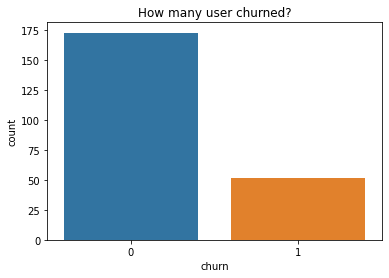

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

num_churn = df_clean.dropDuplicates(['userId', 'churn']).groupby(['churn']).count().toPandas()

ax = sns.barplot(x='churn', y='count', data=num_churn);
plt.xlabel('churn')
plt.ylabel('count')
plt.title('How many user churned?');

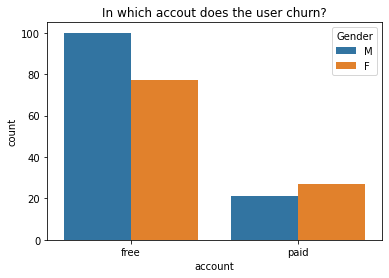

In [14]:
# level (account) of the user
account_churn = df_clean.dropDuplicates(['userId', 'gender']).groupby(['gender', 'level']).count().toPandas()

ax = sns.barplot(x='level', y='count',hue='gender', data=account_churn);
plt.xlabel('account')
plt.ylabel('count')
plt.title('In which accout does the user churn?')
plt.legend(title='Gender', loc='best');

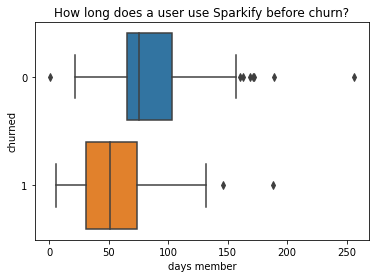

In [15]:
# lifetime (membership) of the users
lifetime = df_clean.select('userId','registration','ts','churn')
lifetime = lifetime.withColumn('lifetime',(df_clean.ts - df_clean.registration)/(1000*3600*24)).groupBy('userId','churn').agg({'lifetime':'max'})
lifetime = lifetime.withColumnRenamed('max(lifetime)','lifetime').select('userId', 'churn', 'lifetime').toPandas()

ax = sns.boxplot(x='lifetime', y='churn', data=lifetime, orient='h');
plt.xlabel('days member');
plt.ylabel('churned');
plt.title('How long does a user use Sparkify before churn?');

# Feature Engineering

In [16]:
# gender of the user
gender = df_clean.select(['userId', 'gender']).dropDuplicates(['userId']).replace(['F', 'M'], ['0', '1'], 'gender')
df_gender = gender.withColumn('gender', gender.gender.cast('int'))
df_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    10|     1|
|   100|     1|
|100001|     0|
|100002|     0|
|100003|     0|
+------+------+
only showing top 5 rows



In [17]:
# level of the user
payment = df_clean.select(['userId', 'level']).dropDuplicates(['userId']).replace(['paid', 'free'], ['0', '1'], 'level')
df_payment = payment.withColumn('level', payment.level.cast('int'))
df_payment.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
+------+-----+
only showing top 5 rows



In [18]:
# did the user downgrade
downgrade = df_clean.select(['userId','downgrade']).dropDuplicates(['userId']) 
df_downgrade = downgrade.withColumn('downgrade', downgrade.downgrade.cast('int'))
df_downgrade.show(5)

+------+---------+
|userId|downgrade|
+------+---------+
|    10|        0|
|   100|        1|
|100001|        0|
|100002|        0|
|100003|        0|
+------+---------+
only showing top 5 rows



In [19]:
# did the user churn
churn = df_clean.select(['userId','churn']).dropDuplicates(['userId'])
df_churn = churn.withColumn('churn', churn.churn.cast('int'))
df_churn.show(5) 

+------+-----+
|userId|churn|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
+------+-----+
only showing top 5 rows



In [20]:
# number of songs the user listened to in total
num_songs = df_clean.select('userID','song').groupBy('userID').count()
num_songs.show(5) 

+------+-----+
|userID|count|
+------+-----+
|    51| 2464|
|   124| 4825|
|     7|  201|
|    54| 3437|
|    15| 2278|
+------+-----+
only showing top 5 rows



In [21]:
# number of Thumbs-Up/Down
num_thumbs_up = df_clean.select('userID','page').where(df_clean.page == 'Thumbs Up').groupBy('userID').count().withColumnRenamed('count', 'num_thumbs_up') 
print(num_thumbs_up.show(5))
num_thumbs_down = df_clean.select('userID','page').where(df_clean.page == 'Thumbs Down').groupBy('userID').count().withColumnRenamed('count', 'num_thumbs_down') 
print(num_thumbs_down.show(5)) 

+------+-------------+
|userID|num_thumbs_up|
+------+-------------+
|    51|          100|
|   124|          171|
|    54|          163|
|    15|           81|
|   132|           96|
+------+-------------+
only showing top 5 rows

None
+------+---------------+
|userID|num_thumbs_down|
+------+---------------+
|    51|             21|
|   124|             41|
|     7|              1|
|    15|             14|
|    54|             29|
+------+---------------+
only showing top 5 rows

None


In [22]:
# number of songs added to playlist
num_playlist = df_clean.select('userID','page').where(df_clean.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'num_playlist')
num_playlist.show(5) 

+------+------------+
|userID|num_playlist|
+------+------------+
|    51|          52|
|   124|         118|
|    15|          59|
|    54|          72|
|   101|          61|
+------+------------+
only showing top 5 rows



In [23]:
# number of friends added
num_friends = df_clean.select('userID','page').where(df_clean.page == 'Add Friend').groupBy('userID').count().withColumnRenamed('count', 'num_friend')
num_friends.show(5)


+------+----------+
|userID|num_friend|
+------+----------+
|    51|        28|
|   124|        74|
|     7|         1|
|    54|        33|
|    15|        31|
+------+----------+
only showing top 5 rows



In [24]:
# total length of listening
sum_listened = df_clean.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'sum_listened')
sum_listened.show(5) 

+------+------------------+
|userID|      sum_listened|
+------+------------------+
|    51| 523275.8428000001|
|   124|1012312.0927900004|
|     7|        38034.0871|
|    54| 711344.9195400004|
|    15|477307.60580999986|
+------+------------------+
only showing top 5 rows



In [25]:
# Number of songs listened per session
av_song_session = df_clean.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'av_song_session')
av_song_session.show(5)

+------+------------------+
|userId|   av_song_session|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



In [26]:
# number of artists listened to
num_artists = df_clean.filter(df_clean.page=="NextSong").select(['userId', 'artist']).dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_artists') 
num_artists.show(5) 

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



In [27]:
# time since registration in days
days_member = df_clean.select('userId','ts','registration').withColumn(
    'days_member',((df_clean.ts - df_clean.registration)/1000/3600/24)).groupBy('userId').agg(
    {'days_member':'max'}).withColumnRenamed('max(days_member)','days_member') 
days_member.show(5) 



+------+------------------+
|userId|       days_member|
+------+------------------+
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
|    15|56.513576388888886|
+------+------------------+
only showing top 5 rows



In [28]:
# session count per user
num_session = df_clean.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions') 
num_session.show(5) 

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



In [29]:
# duration of the session
session_start = df_clean.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'start')
session_end = df_clean.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'end')
dur_session = session_start.join(session_end, ['userId', 'sessionId'])
dur_session = dur_session.select('userId', 'sessionId', ((dur_session.end-dur_session.start)/(1000*60*60)).alias('dur_session'))
dur_session.show(5)

+------+---------+-------------------+
|userId|sessionId|        dur_session|
+------+---------+-------------------+
|    92|      358|  4.288611111111111|
|    42|      433| 1.2455555555555555|
|   137|      136|0.32305555555555554|
|   142|      141|  17.57472222222222|
|     9|      262| 1.9794444444444443|
+------+---------+-------------------+
only showing top 5 rows



In [30]:
# list all the features for the model data set
model_features = [df_payment, df_downgrade, df_gender, num_songs,num_thumbs_up, num_thumbs_down, 
                  num_friends, num_playlist, sum_listened, av_song_session, num_artists, 
                  days_member, num_session, dur_session]

# generate the data set for the model 
df_final = df_churn
df_final.persist()

for i, feature_to_join in enumerate(model_features):
    df_final = df_final.join(feature_to_join,'userID','outer')

In [31]:
# drop userID as no longer needed and fill all remaining missing values with 0
df_final = df_final.drop('userID') 
df_final = df_final.na.fill(0)

# show schema of the final data set
df_final.printSchema()

root
 |-- churn: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- count: long (nullable = true)
 |-- num_thumbs_up: long (nullable = true)
 |-- num_thumbs_down: long (nullable = true)
 |-- num_friend: long (nullable = true)
 |-- num_playlist: long (nullable = true)
 |-- sum_listened: double (nullable = false)
 |-- av_song_session: double (nullable = false)
 |-- num_artists: long (nullable = true)
 |-- days_member: double (nullable = false)
 |-- num_sessions: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- dur_session: double (nullable = false)



# Machine Learning

In [32]:
# rename feature churn for the model
df_final = df_final.withColumnRenamed("churn","label")

In [33]:
# vector assembler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=df_final.columns[1:], outputCol="features")
data = assembler.transform(df_final)
data

DataFrame[label: int, level: int, downgrade: int, gender: int, count: bigint, num_thumbs_up: bigint, num_thumbs_down: bigint, num_friend: bigint, num_playlist: bigint, sum_listened: double, av_song_session: double, num_artists: bigint, days_member: double, num_sessions: bigint, sessionId: bigint, dur_session: double, features: vector]

In [34]:
# standard scaler
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

22/06/01 13:49:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [35]:
# drop column "features" - as no longer needed
data = data.drop("features")

In [36]:
# split the data into train and test 
train, test = data.randomSplit([0.8, 0.2], seed=42)

In [37]:
def get_model_metrics(model):
    
    
    true_positive = model.where((model.label==1) & (model.prediction==1)).count()
    true_negtive = model.where((model.label==0) & (model.prediction==0)).count()
    
    false_positive = model.where((model.label==0) & (model.prediction==1)).count()
    false_negative = model.where((model.label==1) & (model.prediction==0)).count()
        
    accuracy = (true_positive + true_negtive) / model.count()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    f1 = 2.0 * (precision * recall) / (precision + recall)
    
    print('Accuracy: ', round(accuracy, 2))
    print('Precision: ', round(precision, 2))
    print('Recall: ', round(recall, 2))
    print('F1-Score: ', round(f1, 2))

In [38]:
from pyspark.ml.classification import LogisticRegression
lr =  LogisticRegression(featuresCol='scaled_features', labelCol='label', maxIter=10, regParam=0.0, elasticNetParam=0)
lr_model = lr.fit(train)
results_lr = lr_model.transform(test)

get_model_metrics(results_lr)

Accuracy:  0.86
Precision:  0.73
Recall:  0.34
F1-Score:  0.46


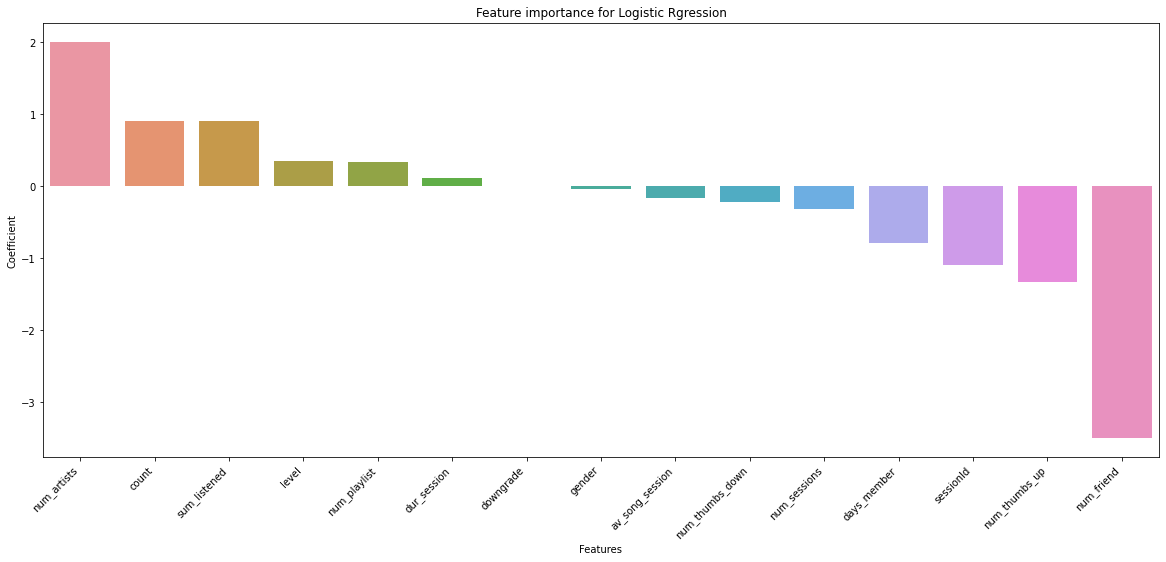

In [39]:
import pandas as pd
feature_coef = lr_model.coefficients.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(df_final.columns[1:], feature_coef)), columns=['Feature', 'Coefficient'])\
        .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,8))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for Logistic Rgression')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

In [40]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features")
dt_model = dt.fit(train)
results_dt = dt_model.transform(test)

get_model_metrics(results_dt)

Accuracy:  0.92
Precision:  0.88
Recall:  0.65
F1-Score:  0.75


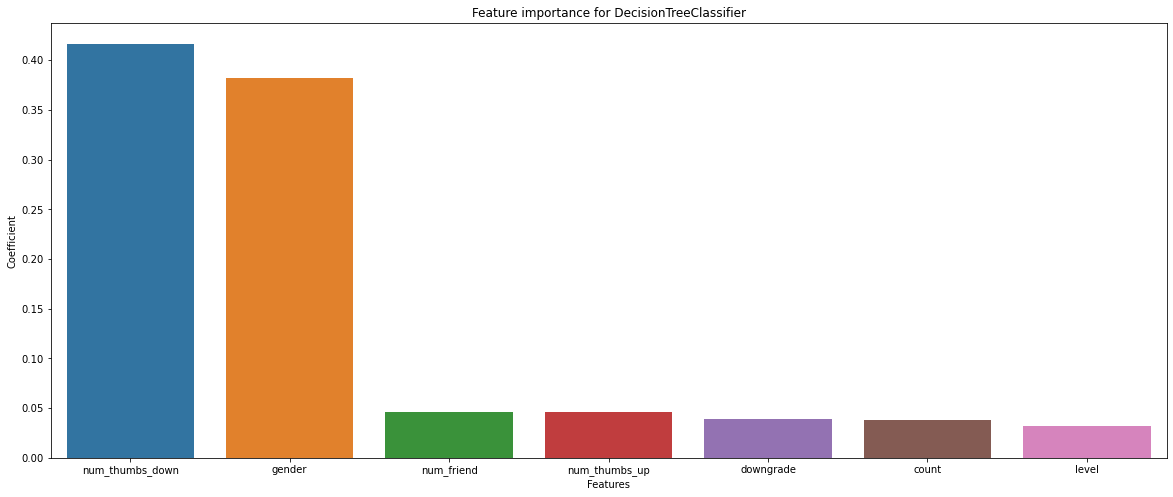

In [41]:
feature_ind = dt_model.featureImportances.indices.tolist()
feature_name = [df_final.columns[1:][ind] for ind in feature_ind]
feature_coef = dt_model.featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(df_final.columns[1:], feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,8))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for DecisionTreeClassifier')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.show()

In [42]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features")
rf_model = rf.fit(train)
results_rf = rf_model.transform(test)

get_model_metrics(results_rf)

Accuracy:  0.93
Precision:  0.95
Recall:  0.65
F1-Score:  0.77


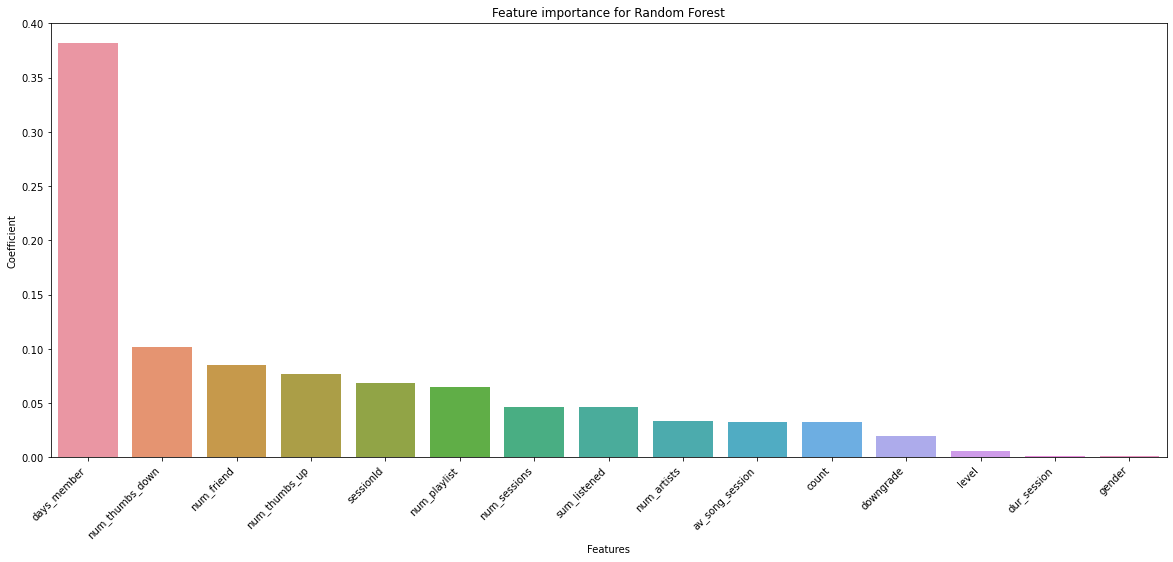

In [43]:
feature_ind = rf_model.featureImportances.indices.tolist()
feature_name = [df_final.columns[1:][ind] for ind in feature_ind]
feature_coef = rf_model.featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(df_final.columns[1:], feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,8))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for Random Forest')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

In [44]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features")
gbt_model = gbt.fit(train)
results_gbt = gbt_model.transform(test)

get_model_metrics(results_gbt)

Accuracy:  0.98
Precision:  0.99
Recall:  0.93
F1-Score:  0.96


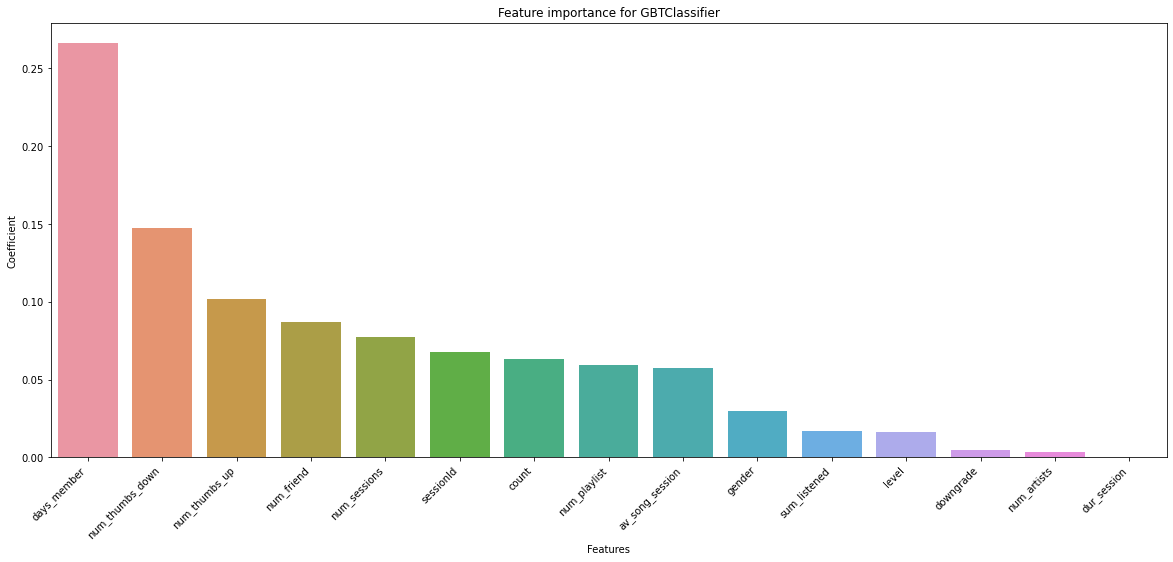

In [45]:
feature_ind = gbt_model.featureImportances.indices.tolist()
feature_name = [df_final.columns[1:][ind] for ind in feature_ind]
feature_coef = gbt_model.featureImportances.values.tolist()
feature_coef_df = pd.DataFrame(list(zip(df_final.columns[1:], feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)

plt.figure(figsize=(20,8))
sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
plt.title('Feature importance for GBTClassifier')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()